In [1]:
import os
from collections import Counter, defaultdict
from itertools import combinations

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import kruskal,wilcoxon,mannwhitneyu
from sklearn.linear_model import Ridge
from tqdm.notebook import tqdm, trange

from tools import extrapolate_advice, greedy_choice, skip_diag_masking
%matplotlib inline

In [11]:
import pandas as pd

# Load data from the CSV file
csv_file = 'responses.csv'  # Replace with the actual file path
df = pd.read_csv(csv_file)

# Extract unique headlines and their associated 'genuine' values
unique_headlines = df.groupby('headline', as_index=False)['genuine'].first()

# Save the unique headlines and genuine values to a new CSV file
output_file = 'headlines.csv'  # Output file name
unique_headlines.to_csv(output_file, index=False)

print(f"Unique headlines with 'genuine' values saved to {output_file}")

Unique headlines with 'genuine' values saved to headlines.csv


In [2]:
figure_dir = "figures"
os.makedirs(figure_dir,exist_ok=True)

## Preprocess responses

In [3]:
prol_data = pd.read_csv("responses.csv")
prol_data["real"]=prol_data.genuine.replace({1:"yes",0:"no"})
prol_data['truth'] = prol_data.genuine.replace({1:"Genuine",0:"Altered"})
prol_data["absolute_error"] = np.abs(prol_data.advice - prol_data.genuine)
prol_data["squared_error"] = (prol_data.advice - prol_data.genuine)**2
prol_data["discrete_error"] = np.abs(extrapolate_advice(prol_data.advice) - prol_data.genuine)
prol_data["accuracy"] = 1-prol_data["discrete_error"]
prol_data['confidence'] = pd.Categorical(prol_data.advice.replace({0:'high',1:'high',0.25:'low',0.75:'low',0.5:'zero'}), ['zero','low','high'])

prol_data.loc[prol_data["expert:age"]=="DATA_EXPIRED","expert:age"] = np.nan
prol_data["expert:age"] = prol_data["expert:age"].astype(float)
prol_data.loc[prol_data["expert:ethnicity"]=="DATA_EXPIRED","expert:ethnicity"] = "NA" 

prol_data["treatment"]=prol_data["treatment"].astype(int)

prol_data.rename({"expert:age":"expert_age","expert:sex":"expert_sex","expert:ethnicity":"expert_ethnicity"},axis=1,inplace=True)
prol_data["headline_group"]= prol_data.apply(lambda x: 'gender' if x['outcome:male']!=0 else 'ethnicity' if x['outcome:black']!=0 else 'age',axis=1)

prol_data = prol_data.sort_values(by=["treatment","trial","arm","expert_id"])

for expert_id in tqdm(prol_data.expert_id.unique()):
    sdata = prol_data.query("expert_id == @expert_id")
    for trial in prol_data.trial.unique():
        trial_error = sdata.query("trial == @trial").absolute_error.mean()
        prol_data.loc[prol_data.eval("expert_id == @expert_id and trial == @trial"),"trial_error"]=trial_error


  0%|          | 0/200 [00:00<?, ?it/s]

## Participant demographics 

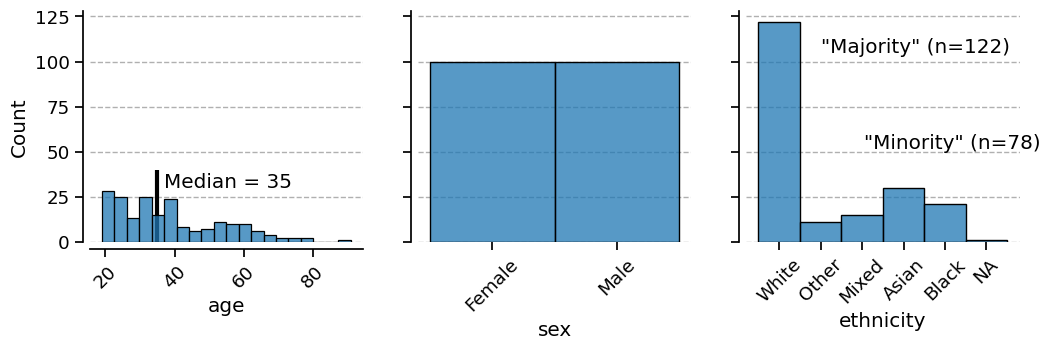

In [4]:

sns.set_context("notebook",font_scale=1.2)

expert_data = prol_data.query("trial==0 and arm ==0")[["expert_id","expert_age","expert_sex","expert_ethnicity"]]

median_age = prol_data.expert_age.median().astype(int)
counts = Counter(expert_data["expert_ethnicity"])

majority_ethnicity, majority_counts = max(counts.items(), key=lambda x: x[1])
other_counts = prol_data.expert_id.nunique() - majority_counts

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches((12, 3))

for i,dem_col in enumerate(('expert_age','expert_sex','expert_ethnicity')):

    g = sns.histplot(sorted(expert_data[dem_col],key=lambda v:v!=majority_ethnicity), stat="count", ax=axs[i],bins=20)
    axs[i].set_xlabel(dem_col.split('_')[1])
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True, axis='y', linestyle='--', alpha=1,zorder=-100) 
    for bar in axs[i].patches:
        bar.set_zorder(100)

sns.despine(ax=axs[0], offset=5, trim=False, bottom=False)
sns.despine(ax=axs[1], offset=5, trim=False, bottom=True)
sns.despine(ax=axs[2], offset=5, trim=False, bottom=True)

axs[0].vlines(x=median_age, ymin=0, ymax=40, color='black', zorder=2,linewidth=3)


axs[0].text(median_age+2,30,f"Median = {median_age}",)
axs[2].text(1,105,f"\"Majority\" (n={majority_counts})",)
axs[2].text(2.05,52,f"\"Minority\" (n={other_counts})",)

plt.savefig(os.path.join(figure_dir,"demographic_histplots.pdf"),bbox_inches="tight")
plt.savefig(os.path.join(figure_dir,"demographic_histplots.svg"),bbox_inches="tight")
plt.show()


## Response distributions

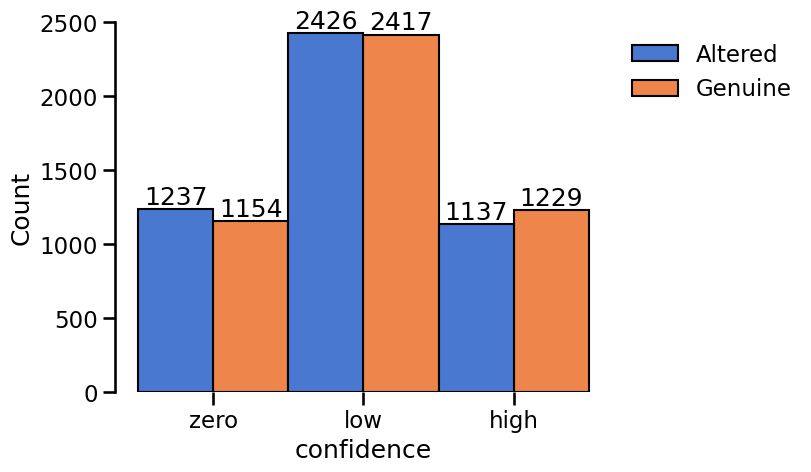

In [5]:
sns.set_context("talk",font_scale=1)

g = sns.histplot(prol_data,x="confidence",stat='count',hue="truth",hue_order=["Altered","Genuine",],multiple="dodge",palette=sns.color_palette("muted")[:2],alpha=1)
total = len(prol_data)

# Iterate over the patches (rectangles representing the bars)
for p in g.patches:
    # Calculating the proportion and formatting it as a string
    proportion = p.get_height()
    # Placing the text above each bar
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), proportion, 
             fontsize=18, ha='center', va='bottom')

g.legend_.set_title(None)
plt.ylim(0,2500)
sns.despine(bottom=True)
sns.move_legend(g, 'upper left',bbox_to_anchor=(1,1),frameon=False)
plt.savefig(os.path.join(figure_dir,"confidence_histogram.pdf"),bbox_inches="tight")
plt.show()

In [6]:

display(prol_data.groupby(by="confidence",observed=True)[["accuracy"]].mean())

,accuracy
confidence,
zero,0.500000
low,0.543671
high,0.605664


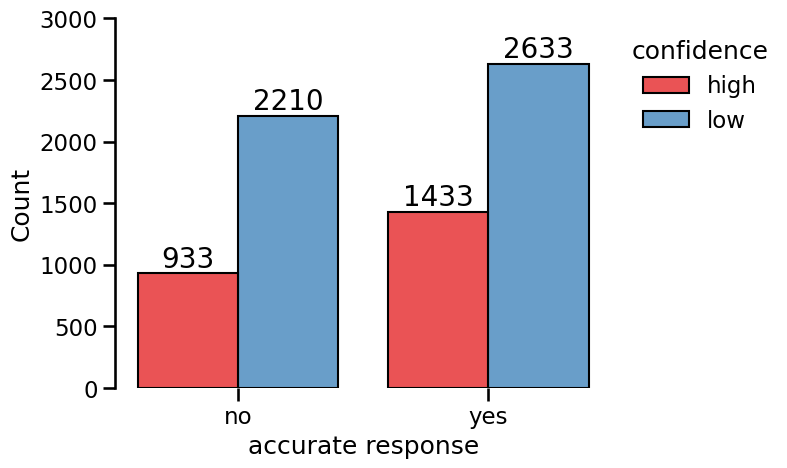

In [7]:

sns.set_context("talk")
sdf = prol_data.query("confidence in ('high','low')").sort_values(by=["expert_id","trial","arm"]).copy()
sdf["confidence"] = pd.Categorical(np.array(sdf["confidence"].values[::]))
sdf["accuracy"] = pd.Categorical(sdf["accuracy"])
g = sns.histplot(data=sdf, x='accuracy', hue='confidence', stat='count', multiple='dodge',bins=2,shrink=.8,palette="Set1")

# Iterate over the patches (rectangles representing the bars)
for p in g.patches:
    # Calculating the proportion and formatting it as a string
    proportion = p.get_height()
    # Placing the text above each bar
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), proportion, 
             fontsize=20, ha='center', va='bottom')

plt.xlabel("accurate response")
plt.xticks([0,1],["no","yes"])
plt.ylabel("Count")
sns.move_legend(g, 'upper left',bbox_to_anchor=(1,1),frameon=False)
plt.ylim(None,3000)
sns.despine(bottom=True)
plt.savefig(os.path.join(figure_dir,"accuracy_histogram.pdf"),bbox_inches="tight")
plt.show()

## Aggregate Errors
### Compute model predictions

In [7]:

def compute_expected_reward(y,advice,K):
    y = y.reshape((-1,K))
    advice = advice.reshape((-1,K))
    choices = greedy_choice(advice,axis=1)
    expected_rewards = (choices*(y-.5)).sum()
    return expected_rewards
for treatment in trange(5,desc="treatment loop"):
    sub_data = prol_data.query("treatment == @treatment").sort_values(by=["trial","arm","expert_id"])[["advice","genuine","headline","outcome:male","outcome:old","outcome:white"]].values.reshape((16,3,-1,6))
    advice = sub_data[...,0]
    outcome = sub_data[...,1][...,0]
    headlines = sub_data[...,2][...,0].reshape((-1,))
    groups = np.abs(sub_data[...,(3,4,5)])[...,0,:].reshape((-1,3))
    
    
    X = advice.reshape((-1,prol_data.query("treatment == @treatment").expert_id.nunique())).astype(float)
    y = outcome.reshape((-1,)).astype(float)

    predictions = {name: np.zeros_like(y, dtype=float) for name in ["metacmab", "expertisetree", "exp4"]}
    
    for i in range(len(X)):
        X_test = X[i].reshape(1, -1).astype(float)
        X_train, y_train = np.delete(X, i, axis=0), np.delete(y, i,  axis=0)
        

        # metacmab's compute a regression over the experts' predictions and uses the coefficients as weights
        metacmab_model = Ridge(fit_intercept=False,alpha=1)
        metacmab_model.fit(X_train, y_train)
        predictions["metacmab"][i] = metacmab_model.predict(X_test)[0]

        # in this setting expertisetree fits a model to points within the same headline group 
        mask = (np.delete(groups, i, axis=0)  == groups[i]).all(axis=1)
        fully_split_model = Ridge(fit_intercept=False,alpha=1)  
        fully_split_model.fit(X_train[mask], y_train[mask])
        predictions["expertisetree"][i] = fully_split_model.predict(X_test)[0]

        # members' weight under exp4 is the exponential of their cumulative gain 
        K=3
        X_train = np.delete(X, np.arange(i//K*K, (i//K+1)*K), axis=0) 
        y_train = np.delete(y, np.arange(i//K*K, (i//K+1)*K), axis=0) 
        
        gains = []
        for n in range(X_train.shape[1]):
            gains.append(compute_expected_reward(y_train,X_train[:,n],K))
        gains = np.array(gains)
        lr = 0.5 * (2 *np.log(X_train.shape[1] + 1) / (K * X_train.shape[0]))**(1 / 2)*(X_train.shape[0]//K)

        weights = np.exp(gains*K*lr)
        weights /= np.sum(weights)
        
        predictions["exp4"][i] = (X[i]*weights).sum()
        
    for headline, pred_linear,pred_fully_split,pred_exp4_weights  in (zip(headlines,predictions["metacmab"],predictions["expertisetree"],predictions["exp4"])):
        
        headline_condition =  (prol_data['headline'] == headline)
    
        prol_data.loc[headline_condition,"average_aggregate"] = prol_data.loc[headline_condition].advice.mean()
        prol_data.loc[headline_condition,"metacmab_aggregate"] = pred_linear
        prol_data.loc[headline_condition,"expertisetree_aggregate"] = pred_fully_split
        prol_data.loc[headline_condition,"exp4_aggregate"] = pred_exp4_weights 



treatment loop:   0%|          | 0/5 [00:00<?, ?it/s]

### Analyse model error as a function of headline group (age, gender, ethnicity) and headline status (altered or genuine)

In [8]:
err_df = prol_data.groupby(by=["headline","headline_group","outcome:male","outcome:white","outcome:old"]).mean(numeric_only=True).reset_index()
err_df["average_error"] = np.abs(err_df["average_aggregate"]-err_df["genuine"])
err_df["metacmab_error"] = np.abs(err_df["metacmab_aggregate"]-err_df["genuine"])
err_df["expertisetree_error"] = np.abs(err_df["expertisetree_aggregate"]-err_df["genuine"])
err_df["exp4_error"] = np.abs(err_df["exp4_aggregate"]-err_df["genuine"])
err_df["sentiment"]=(err_df[["outcome:male","outcome:white","outcome:old"]].min(axis=1)).map({-1:'negative',0:'positive'})

for error_name in ['average_error','metacmab_error','expertisetree_error','exp4_error']:
    print(error_name)

    ind = sm.cov_struct.Exchangeable() 
    model = sm.GEE.from_formula(f"{error_name} ~  headline_group   * genuine ", 
                                groups="treatment", 
                                cov_struct=ind, 
                                time="trial",
                                data=err_df)
    result = model.fit()
    # print(result.summary())
    print(result.conf_int())

    params = result.params
    bse = result.bse
    tvalues = result.tvalues
    pvalues = result.pvalues

    latex_table = "\\begin{table}[!htbp] \n\\centering \n"
    latex_table += "\\begin{tabular}{lcccc} \n \\toprule \n"
    latex_table += "Parameter & Estimate & Std. Error & t-value & $p$-value \\\\ \n \\midrule \n"

    for param in params.index:
        param_escaped = param.replace("_", "\\_") 
        p_value = pvalues[param]
        p_str = f"{p_value:.3f}" if p_value > 0.001 else "$<$ 0.001"
        latex_table += f"{param_escaped} & {params[param]:.3f} & {bse[param]:.3f} & {tvalues[param]:.3f} & {p_str} \\\\ \n"

    latex_table += """\\bottomrule \n\end{tabular} \n\caption{GEE summary for """+ error_name +""". } \n\label{tab:gee_"""+ error_name +"""}  \n\end{table*}"""
    latex_table = latex_table.replace("headline\_group[T.ethnicity]","Headline Class: Ethnicity")
    latex_table = latex_table.replace("headline\_group[T.gender]","Headline Class: Gender")
    latex_table = latex_table.replace("genuine","Genuine")
    latex_table = latex_table.replace("headline\_group[T.ethnicity]:genuine","Gender+Genuine")
    latex_table = latex_table.replace("headline\_group[T.gender]:genuine","Ethnicity+Genuine")
    print(latex_table)
    print("="*50)

average_error
                                            0         1
Intercept                            0.535553  0.622572
headline_group[T.ethnicity]         -0.203915 -0.066710
headline_group[T.gender]            -0.186319 -0.000556
genuine                             -0.283565 -0.124873
headline_group[T.ethnicity]:genuine  0.105476  0.332337
headline_group[T.gender]:genuine     0.030154  0.278908
\begin{table}[!htbp] 
\centering 
\begin{tabular}{lcccc} 
 \toprule 
Parameter & Estimate & Std. Error & t-value & $p$-value \\ 
 \midrule 
Intercept & 0.579 & 0.022 & 26.085 & $<$ 0.001 \\ 
Headline Class: Ethnicity & -0.135 & 0.035 & -3.866 & $<$ 0.001 \\ 
Headline Class: Gender & -0.093 & 0.047 & -1.972 & 0.049 \\ 
Genuine & -0.204 & 0.040 & -5.045 & $<$ 0.001 \\ 
Headline Class: Ethnicity:Genuine & 0.219 & 0.058 & 3.782 & $<$ 0.001 \\ 
Headline Class: Gender:Genuine & 0.155 & 0.063 & 2.435 & 0.015 \\ 
\bottomrule 
\end{tabular} 
\caption{GEE summary for average_error. } 
\label{tab:g

## Error of the simple average as a function of headline groups, sentiment, and outcome

Kruskal-Wallis H-test: H=34.16678215500062, p=1.8268986336750855e-07
Degrees of Freedom: 3
Effect Size (Eta-squared): 0.4100892388815871


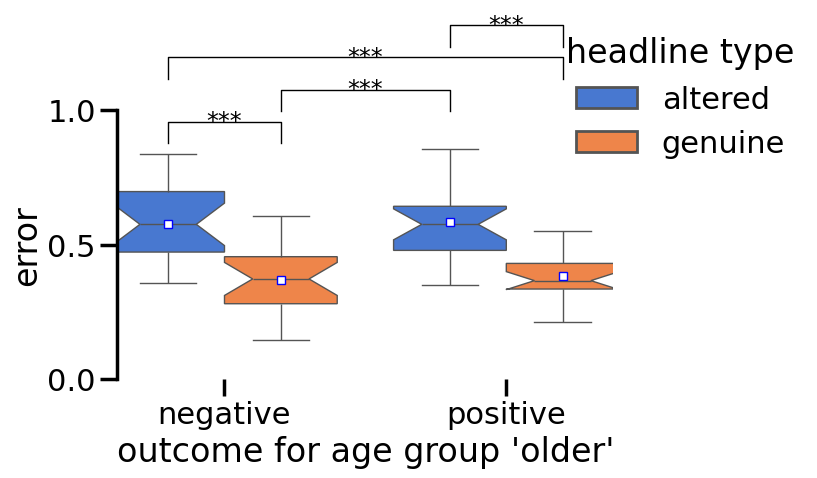

Kruskal-Wallis H-test: H=33.99523789977371, p=1.9857790500435626e-07
Degrees of Freedom: 3
Effect Size (Eta-squared): 0.40783207762860146


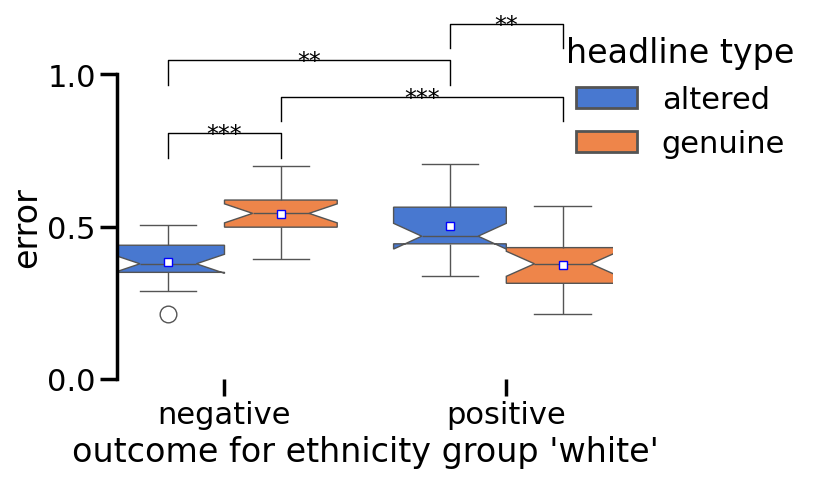

Kruskal-Wallis H-test: H=10.4210074718778, p=0.015306435670637388
Degrees of Freedom: 3
Effect Size (Eta-squared): 0.09764483515628684


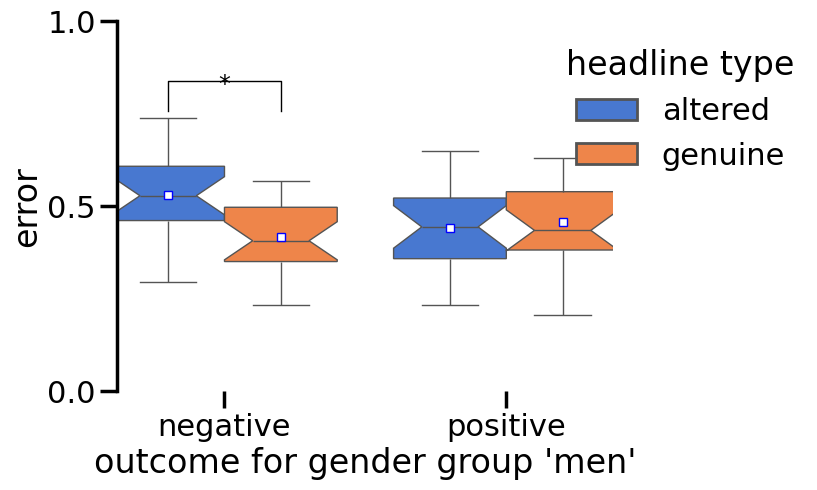

In [9]:

for headline_group_name in ["age","ethnicity","gender"]:
    sns.set_context("poster")
    subdf = err_df[err_df['headline_group']==headline_group_name].sort_values(by="sentiment").copy() #age
    subdf["genuine"]=subdf.genuine.replace({1:"genuine",0:"altered"})

    g=sns.boxplot(subdf,y="average_error",x="sentiment",hue="genuine",notch=True,hue_order=["altered","genuine",],palette=sns.color_palette("muted")[:2],saturation=1,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})


    # Extract the number of levels and their names
    levels = [(x, str(y)) for x in sorted(subdf['sentiment'].unique(),reverse=False) for y in sorted(subdf['genuine'].unique(),reverse=False)]

    # Combine 'headline_group_label' and 'outcome' as a single label for MultiComparison
    subdf['combined_label'] = subdf[['sentiment', 'genuine']].astype(str).agg('_'.join, axis=1)

    # Initialize the y-coordinate for annotations
    y_max = subdf['average_error'].max() + .02  # Adjust as necessary

    def draw_bracket(ax, x1, x2, y, h):
        line_x = [x1, x1, x2, x2]
        line_y = [y, y + h, y + h, y]
        ax.plot(line_x, line_y, color='k', linewidth=1)

    group_vals = []
    labels =[]
    for v in subdf['combined_label'].unique():
        labels.append(tuple(v.split("_")))
        group_vals.append(subdf.query("combined_label == @v")['average_error'].values)
 
    stat, p_value = kruskal(*group_vals)
    print(f"Kruskal-Wallis H-test: H={stat}, p={p_value}")
    # Calculate degrees of freedom
    df = len(group_vals) - 1
    print(f"Degrees of Freedom: {df}")

    # Calculate Eta-squared for effect size (assuming you have N, the total sample size)
    N = sum(len(group) for group in group_vals)
    eta_squared = (stat - (len(group_vals) - 1)) / (N - len(group_vals))
    print(f"Effect Size (Eta-squared): {eta_squared}")
    result = sp.posthoc_dunn(group_vals, p_adjust='bonferroni')
    
    for i, (id_1, id_2) in enumerate(combinations(np.arange(len(labels)), 2)):
        if result[id_1+1][id_2+1]<0.10:  # If the pair is significantly different
            group1,group2 = labels[id_1],labels[id_2]
  
  
            height = 0.08  # Adjust as needed
            def map_pos(pos):
                return [-.2,.2,.8,1.2,1.8,2.2][pos]
            pos1 = map_pos(levels.index(group1))
            pos2 = map_pos(levels.index(group2))
            
            draw_bracket(g, pos1, pos2, y_max, height)
            p =result[id_1+1][id_2+1]
            p_val_str = '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else '' 
            plt.text(((pos1+pos2)/2), y_max+height/2,p_val_str, ha='center', va='bottom', fontsize=17)

            # Adjust y_max for next annotation
            y_max += 1.5*height  # Adjust as needed to avoid overlapping annotations

    plt.yticks([0,0.5,1])
    sns.move_legend(g, "upper left", bbox_to_anchor=(.85,1),title='headline type',frameon=False)
    sns.despine(top=True,right=True,bottom=True,trim=True)
    group_names = {'age':'older','gender':'men','ethnicity':'white'}
    plt.xlabel(f"outcome for {headline_group_name} group '{group_names[headline_group_name]}'")

    plt.ylabel("error")
    plt.gca().yaxis.set_label_coords(-0.15, .5/plt.ylim()[1])

    g.get_figure().align_labels()
    plt.savefig(os.path.join(figure_dir,f"error_by_{headline_group_name}_sentiment.pdf"),bbox_inches="tight")
    plt.show()

### difference in accuracy between (confidence) weighted average and average

In [11]:

ovs=[]
accuracies=[]
confidences=[]
for treatment in range(5):
    vs = prol_data.query("treatment == @treatment").sort_values(by=["trial","arm"])
    a = vs.advice.values.reshape((-1,vs.expert_id.nunique()))
    o=vs.genuine.values.reshape((-1,vs.expert_id.nunique()))[...,0]


    weighted_mean = extrapolate_advice(a.mean(axis=1)).astype(float)
    thresholded_mean = (extrapolate_advice(extrapolate_advice(a)).mean(axis=1)).astype(float)
    weighted_error = np.abs(weighted_mean-o)
    thresholded_error = np.abs(thresholded_mean-o)
    ovs.append((weighted_error,thresholded_error))
accuracy_confidence_weighted_average,accuracy_average,  =1-np.mean(ovs,axis=(0,2))
print("accuracy of the average:",accuracy_average)
print("accuracy of the confidence weighted average:", accuracy_confidence_weighted_average)

classifier_a,classifier_b = np.rollaxis(np.array(ovs),0,2).reshape((2,-1))
print("significance:",wilcoxon(classifier_a,classifier_b))

accuracy of the average: 0.5480729166666667
accuracy of the confidence weighted average: 0.6395833333333334
significance: WilcoxonResult(statistic=10872.0, pvalue=0.0008590662879807013)


### difference in accuracy between averages over men vs over women

In [12]:

ovs=[]
accuracies=[]
confidences=[]

for treatment in range(5):
    vs1 = prol_data[(prol_data["treatment"] == treatment)&(prol_data["expert_sex"] == "Male")].sort_values(by=["trial","arm"])
    a = vs1.advice.values.reshape((-1,vs1.expert_id.nunique()))
    o = vs1.genuine.values.reshape((-1,vs1.expert_id.nunique()))[...,0]

    weighted_mean = (a).mean(axis=1)
    weighted_error = np.abs(extrapolate_advice(weighted_mean).astype(float)-o)

    vs2 = prol_data[(prol_data["treatment"] == treatment)&(prol_data["expert_sex"] == "Female")].sort_values(by=["trial","arm"])
    a = vs2.advice.values.reshape((-1,vs2.expert_id.nunique()))

    o = vs2.genuine.values.reshape((-1,vs2.expert_id.nunique()))[...,0]

    p=0
    weighted_mean = (a).mean(axis=1)
    weighted_error2 = np.abs(extrapolate_advice(weighted_mean)-o)

    ovs.append((weighted_error,weighted_error2))
accuracy_male_average,accuracy_female_average  =1-np.mean(ovs,axis=(0,2))
print("accuracy of male group:",accuracy_male_average)
print("accuracy of female group:", accuracy_female_average)
classifier_a,classifier_b = np.rollaxis(np.array(ovs),0,2).reshape((2,-1))
print("significance:",wilcoxon(classifier_a,classifier_b))

accuracy of male group: 0.6270833333333333
accuracy of female group: 0.59375
significance: WilcoxonResult(statistic=769.0, pvalue=0.2500820288556844)


### computing correlation of male vs female vs mixed groups

In [13]:
np.random.seed(0)

all_cors=[]
for treatment in range(5):
    a1 = prol_data.query("treatment == @treatment and expert_sex == 'Female'").sort_values(by=["expert_id","headline"]).advice.values.reshape((-1,48))
    a2 = prol_data.query("treatment == @treatment and expert_sex == 'Male'").sort_values(by=["expert_id","headline"]).advice.values.reshape((-1,48))

    for i in range(1000):
        subset_size=20
        idx1 = np.random.choice(len(a1),size=subset_size,replace=False)
        idx2 = np.random.choice(len(a2),size=subset_size,replace=False)
        
        a_mixed = np.vstack((a1[idx1[::2]],a2[idx2[::2]]))

        all_cors.append((skip_diag_masking(np.corrcoef(a1[idx1])).mean(),skip_diag_masking(np.corrcoef(a2[idx2])).mean(),skip_diag_masking(np.corrcoef(a_mixed)).mean()))

print("correlation of groups [female, male, mixed]:",np.mean(all_cors,axis=0))

correlation of groups [female, male, mixed]: [0.21973802 0.17837684 0.19490665]


## Confidence distributions by demographic groups

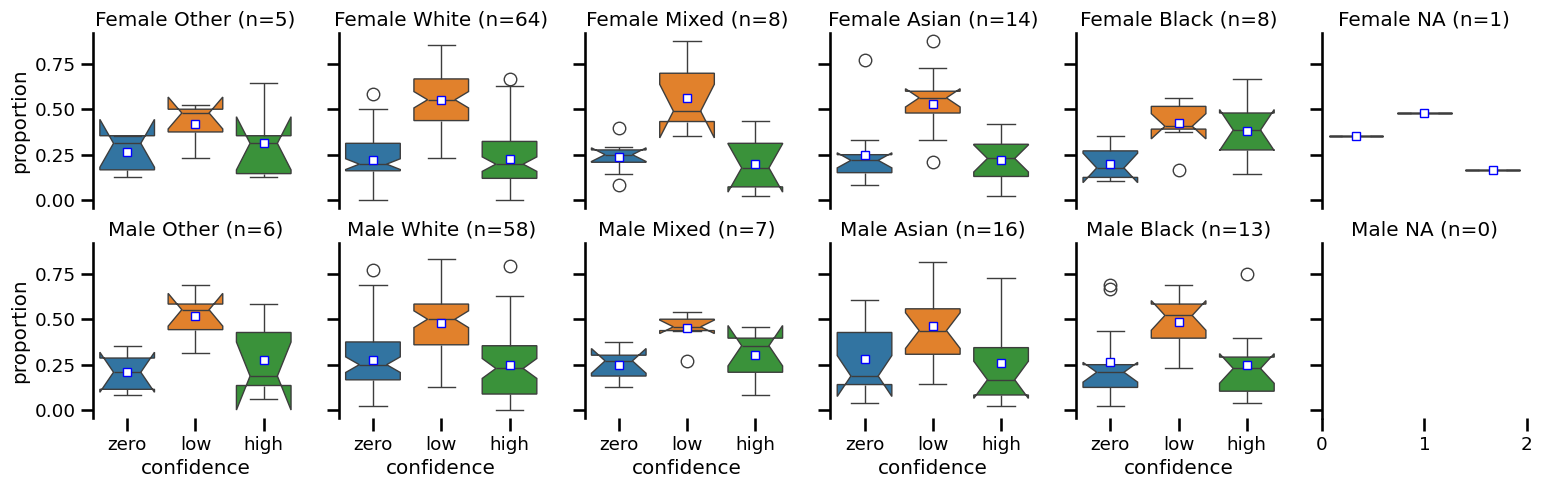

In [14]:
prol_data["age cat"] = prol_data["expert_age"]>np.nanmedian(prol_data["expert_age"])
prol_data["age cat"] = prol_data["age cat"].map(lambda b: ">35" if b else "<=35")
            
sns.set_context("talk",font_scale=.8)
expert_genders = [v for v in prol_data['expert_sex'].unique() if v not in ('CONSENT_REVOKED','DATA_EXPIRED')]
expert_eths =  [v for v in prol_data['expert_ethnicity'].unique() if v not in ('CONSENT_REVOKED','DATA_EXPIRED')]
for target_name in ("advice",):
    fig,axs = plt.subplots(len(expert_genders),len(expert_eths),sharey=True)
    state_components = ['outcome','positive','sex:male','ethnicity:black','age:young']
    fig.set_size_inches(18.5, 5)
    N_SIMS=1
    for eg,expert_gender in enumerate(expert_genders):
        for ee,expert_eth in enumerate(expert_eths):
            means_irrelevant = []
            importances=[]
            confidences = prol_data[(prol_data['expert_sex']==expert_gender)&(prol_data['expert_ethnicity']==expert_eth)].confidence
            d = prol_data[(prol_data['expert_sex']==expert_gender)&(prol_data['expert_ethnicity']==expert_eth)].groupby(by=["expert_id","confidence"],observed=False).count().reset_index().copy()
            d["age cat"]="tmp"
            for expert_id in d.expert_id.unique():
                d.loc[d.eval("expert_id == @expert_id"),"age cat"] = prol_data.query("expert_id == @expert_id")["age cat"].values[0]
            counts = d[["confidence","original","age cat"]].copy()
            counts["original"]/=48
            counts.columns = ["confidence","proportion","age category"]
            sns.boxplot(counts,ax=axs[eg,ee],x="confidence",y="proportion",hue="confidence",showmeans=True,notch=True,order=["zero","low","high"],meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
          
            if eg==1:
                axs[eg,ee].set_xticks([0,1,2])
            else:
                axs[eg,ee].set_xticks([])
                axs[eg,ee].set_xlabel(None)
            if ee==0: 
                axs[eg,ee].set_ylabel("proportion")
            else:
                axs[eg,ee].set_ylabel(None)
            axs[eg,ee].set_title(f"{expert_gender} {expert_eth} (n={len(confidences)//(16*3)})")
            sns.despine(ax=axs[eg,ee],bottom=True)
            pass
    plt.savefig(os.path.join(figure_dir,f"confidence_boxplots.pdf"),bbox_inches="tight")
    plt.show()

### Expertise by demographic data

significantly different accuracy: 0.554375 vs expert_sex[T.Male] 0.5240625
confidence intervals:


,0,1
Intercept,0.517279,0.591471
expert_sex[T.Male],-0.053496,-0.007129


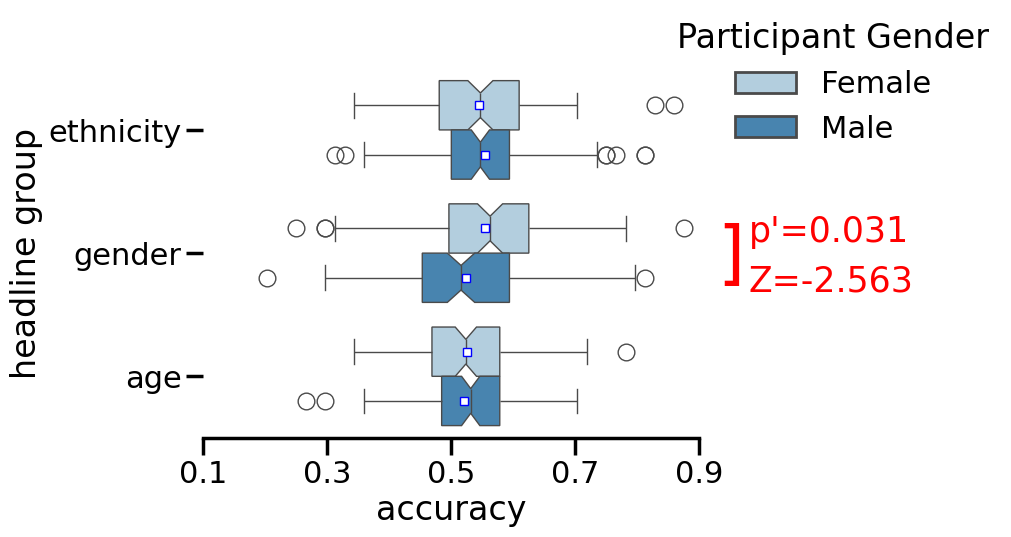

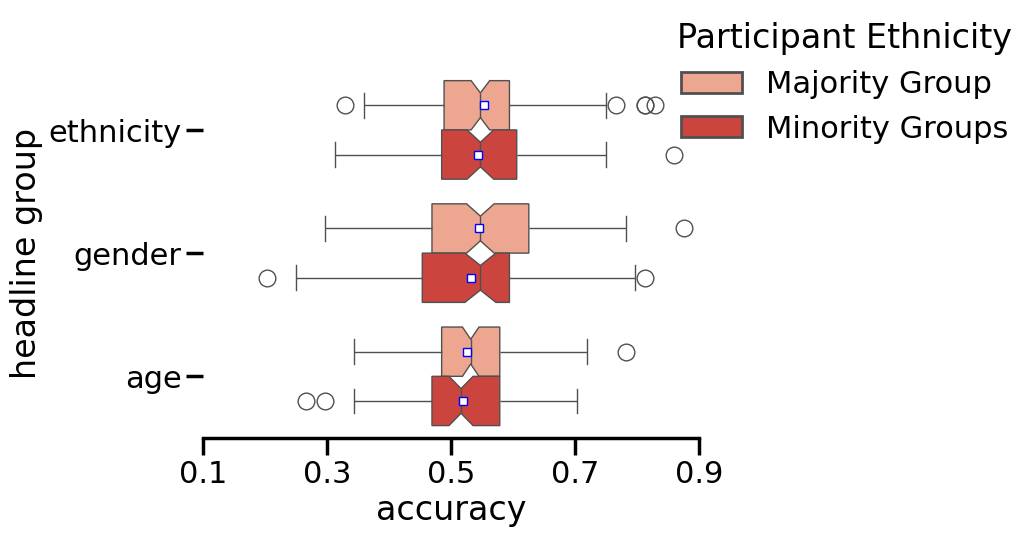

significantly different accuracy: 0.510631443298969 vs age_catf[T.≤median (35)] 0.5347390776699028
confidence intervals:


,0,1
Intercept,0.492883,0.528379
age_catf[T.≤median (35)],0.005054,0.043161


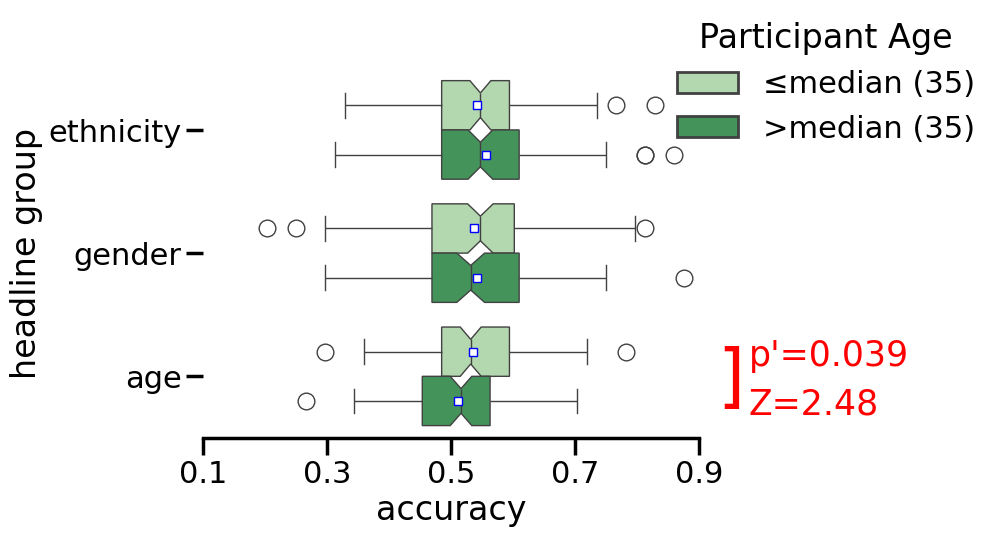

In [15]:
prol_data["expertethnicity"] = prol_data["expert_ethnicity"].map(lambda s:"Majority Group" if s=="White" else "Minority Groups")
filtered_data = prol_data.groupby(by=["expert_sex","expertethnicity","age cat","headline_group","expert_id","treatment"]).mean(numeric_only=True)[["absolute_error"]].reset_index()
filtered_data["age_catf"]=filtered_data["age cat"].map(lambda s:"≤median (35)" if s=="<=35" else ">median (35)")
plt.rcParams['text.usetex'] = False
sns.set_context("poster")
# Assuming you have loaded your dataset as filtered_data
palettes = ["Blues","Reds","Greens"]
filtered_data["accuracy"]=1-filtered_data["absolute_error"]
target="accuracy"
groups = ["ethnicity","gender","age"]
for feat in ("expert_sex","expertethnicity","age_catf"):

    boxprops = dict(linestyle='-', linewidth=4, color='k')
    ax = sns.boxplot(data=filtered_data, x=target, hue=feat, y="headline_group",order=groups, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"},notch=True,palette=palettes[0], showmeans=True)

    palettes=palettes[1:]
    expertethnicity_levels = filtered_data[feat].unique()

    # Validate we have only two levels
    if len(expertethnicity_levels) != 2:
        raise ValueError('There are more or less than two levels in "expertethnicity" column.')

    for group in groups:
        group_data = filtered_data[filtered_data['headline_group'] == group]
        
        model = smf.gee(target+" ~ "+feat, data=group_data, groups="treatment").fit()
        statistic,p_value = model.tvalues.values[1],model.pvalues.iloc[1]

        if p_value*3<0.05:
            print("significantly different accuracy:",model.params.iloc[0],"vs",list(model.params.keys())[1],model.params.iloc[0]+model.params.iloc[1])
            print("confidence intervals:")
            display(model.conf_int())
            y_position = groups.index(group) 
            ax.text(.95, y_position+.025, ']', ha='center', va='center', color='red', fontsize=50)
            ax.text(.98, y_position-.17, 'p\'='+ str(np.round(p_value*3,3)), ha='left', va='center', color='red', fontsize=25)
            ax.text(.98, y_position+.23, 'Z='+ str(np.round(statistic,3)), ha='left', va='center', color='red', fontsize=25)
    sns.despine(left=True)
    sns.move_legend(ax,"upper left",title={"expert_sex":"Participant Gender","expertethnicity":"Participant Ethnicity","age_catf":"Participant Age"}[feat],bbox_to_anchor=(.9, 1.2),frameon=False)
    plt.xticks([0.1,.3,0.5,.7,0.9])
    
    plt.xlim(0.1,0.9)
    plt.xlabel("accuracy")
    plt.ylabel("headline group")
    plt.savefig(os.path.join(figure_dir,f"error_by_{feat}.pdf"),bbox_inches="tight")
    plt.show()


## Headline distributions

(i) real headline "Blacks Are Less Likely Than Whites to Get Treatment for Heart Disorder" and altered version "Whites Are Less Likely Than Blacks to Get Treatment for Heart Disorder"
(ii) real headline "Patients Treated by Female Doctors Less Likely to Die Than Patients Treated by Men, New Study Shows" and altered version "Patients Treated by Male Doctors Less Likely to Die Than Patients Treated by Women, New Study Shows"
(iii) real headline "Study Says Women Receive Diagnoses Years Later Than Men" and altered version "Study Says Men Receive Diagnoses Years Later Than Women"
(iv) real headline "Young Adults More Likely to Read Than Those Who Are over 30" and altered version "Older Adults More Likely to Read Than Those Who Are under 30"


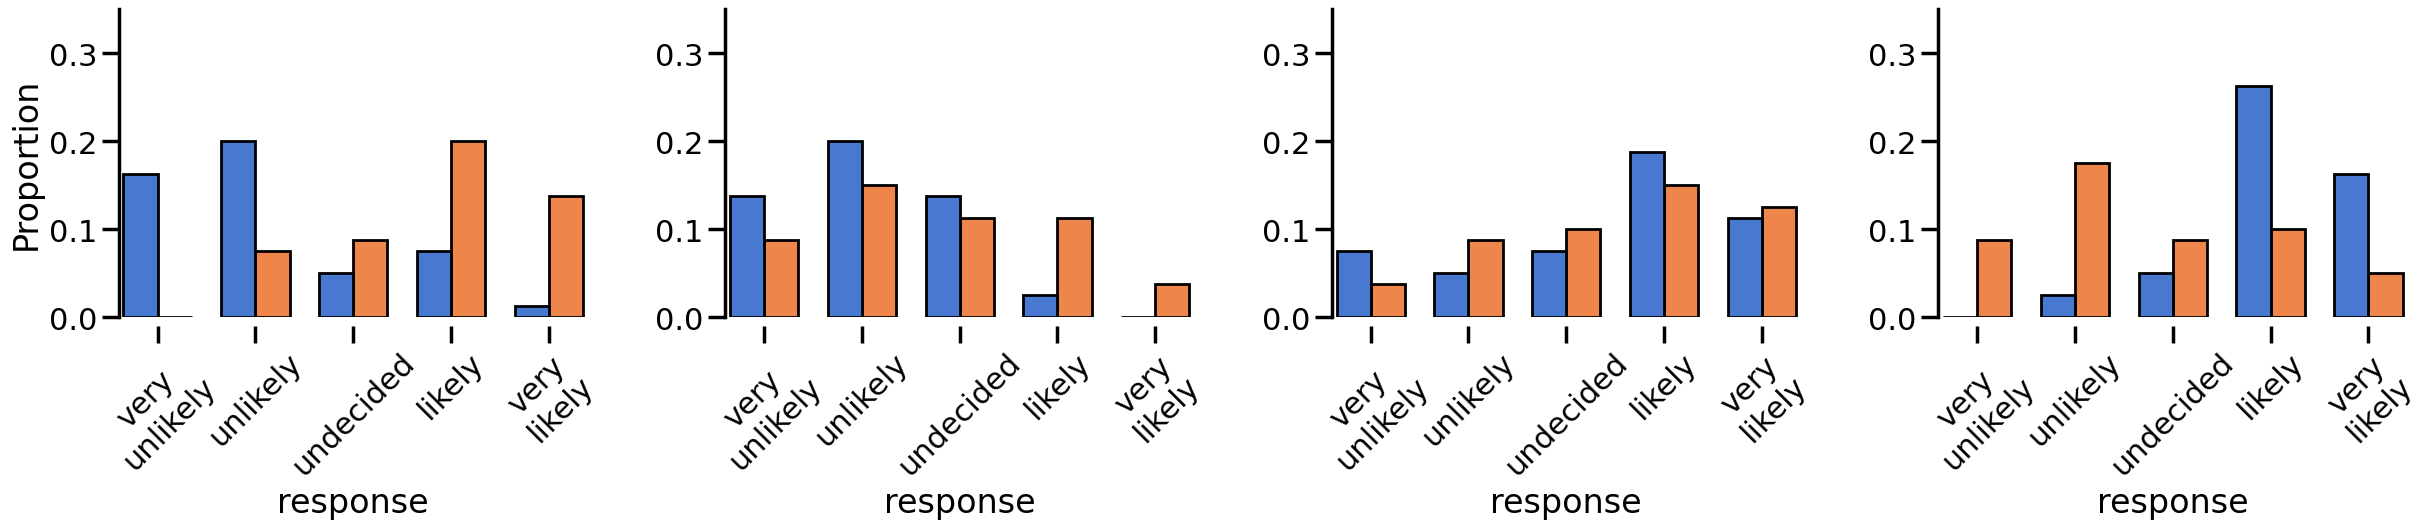

proportion of headlines for which the complementary advice distribution is significantly different from the complement: 0.44166666666666665


In [16]:

sns.set_context("poster")
distances = []
emds=[]
points=defaultdict(list)
emds_group=[]
emds_expertisetree=[]
emds_exp=[]
consistency_ps =[]
classes=[]
display_headlines = ('Blacks Are Less Likely Than Whites to Get Treatment for Heart Disorder',
                    'Study Says Women Receive Diagnoses Years Later Than Men','Young Adults More Likely to Read Than Those Who Are over 30',
                    'Patients Treated by Female Doctors Less Likely to Die Than Patients Treated by Men, New Study Shows')
fig,axs = plt.subplots(1,4,figsize=(30,4))
quadrants = defaultdict(list)
headline_quadrants = defaultdict(list)
for h in prol_data.original.unique():
    v = prol_data.query("original == @h").sort_values("genuine").copy()
    
    real = (v.query("genuine==1").advice.values)
    fake = (v.query("genuine==0").advice.values)

    quadrants[(np.mean(real)>=0.5,np.mean(fake)>=.5)].append((np.mean(real),np.mean(fake)))
    headline_quadrants[(np.mean(real)>=0.5,np.mean(fake)>=.5)].append(h)



display_headlines = sorted(display_headlines)
colors=[]
labels="abcd"
for h in sorted(prol_data.original.unique()):
    v = prol_data.query("original == @h").sort_values("genuine").copy()
    
    real = (v.query("genuine==1").advice.values)
    fake = (v.query("genuine==0").advice.values)


    avg_advice_fake,avg_advice_real = (v.groupby("genuine").mean(numeric_only=True).reset_index().sort_values(by="genuine").advice.values)
   
    metacmab_advice_fake,metacmab_advice_real = (v.groupby("genuine").mean(numeric_only=True).reset_index().sort_values(by="genuine").metacmab_aggregate.values-.5)/np.abs(prol_data.metacmab_aggregate.values-.5).max()/2+.5
   
    expertisetree_advice_fake,expertisetree_advice_real = (v.groupby("genuine").mean(numeric_only=True).reset_index().sort_values(by="genuine").expertisetree_aggregate.values-.5)/np.abs(prol_data.expertisetree_aggregate.values-.5).max()/2+.5
   
    exp4_advice_fake,exp4_advice_real = (v.groupby("genuine").mean(numeric_only=True).reset_index().sort_values(by="genuine").exp4_aggregate.values)
   

    confidence = 0.95


    mean = np.mean(real)

    classes.append(tuple(np.abs(prol_data.query("original == @h")[["outcome:male","outcome:old","outcome:white"]].values[0])))
    classes[-1] = "gender" if classes[-1][0] == 1 else "age" if classes[-1][1] else "ethnicity"
   
    
    stat,pval = mannwhitneyu(real,1-fake)
    points["average"].append((np.mean(real),np.mean(fake)))
    points["metacmab"].append((metacmab_advice_real,metacmab_advice_fake))
    points["expertisetree"].append((expertisetree_advice_real,expertisetree_advice_fake))
    points["exp4"].append((exp4_advice_real,exp4_advice_fake))
    
    consistency_ps.append((pval,))
    labels=["i","ii","iii","iv"]
    if h in (display_headlines):
        hi = display_headlines.index(h)
        colors.append("C1")
        
        altered_version = [hl for hl in v.headline.unique() if hl!=h][0]
        print(f"({labels[hi]})",f'real headline "{h}" and altered version "{altered_version}"')
        
        v["real"]=v["real"].map(lambda s:"altered" if s=='no' else "real")
        sns.histplot(v,ax=axs[hi],x='advice',hue='real',multiple='dodge',stat="proportion",bins=[-0.125,0.125,0.375,0.625,0.875,1.125],shrink=.7,legend=None,palette=sns.color_palette("muted")[:2],alpha=1)

        if hi>0:
            axs[hi].set_ylabel("")
        axs[hi].set_xlabel("response")
        
        axs[hi].set_xticks([0,0.25,0.5,0.75,1],["very\nunlikely","unlikely","undecided","likely","very\nlikely"],rotation=45)
        axs[hi].tick_params(axis='x', rotation=45)
        axs[hi].set_ylim(0,0.35)
        axs[hi].set_yticks([0,0.1,0.2,0.3])
        
        
        
        axs[hi].spines['left'].set_position(('data', -.1))
        axs[hi].spines['bottom'].set_position(('data', -.01))
        
        sns.despine(bottom=True)
        
        labels=labels[1:]
    else:
        colors.append("C0")
plt.savefig(os.path.join(figure_dir,f"histograms.svg"),bbox_inches="tight")
plt.show()
print("proportion of headlines for which the complementary advice distribution is significantly different from the complement:", (np.array(consistency_ps)<0.05).mean())

## Distribution of aggregate predictions

average - quantile counts: Counter({'Q3': 52, 'Q2': 34, 'Q1': 19, 'Q4': 15})


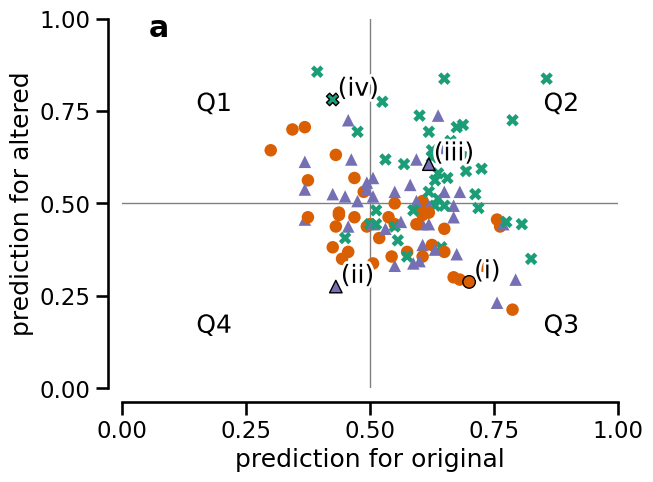

metacmab - quantile counts: Counter({'Q3': 61, 'Q2': 26, 'Q4': 25, 'Q1': 8})


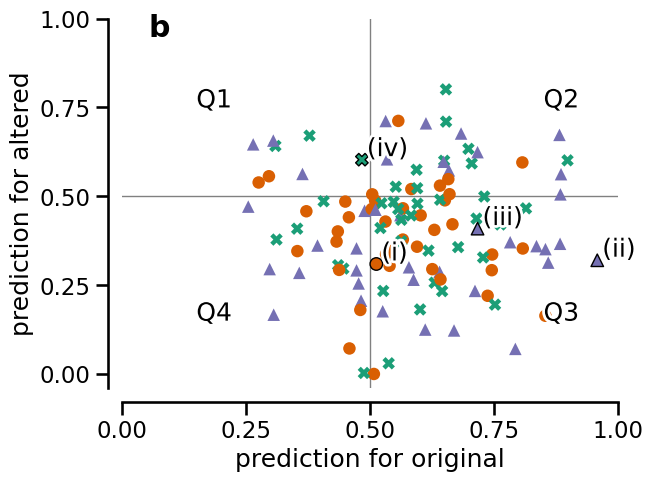

expertisetree - quantile counts: Counter({'Q3': 97, 'Q2': 11, 'Q4': 8, 'Q1': 4})


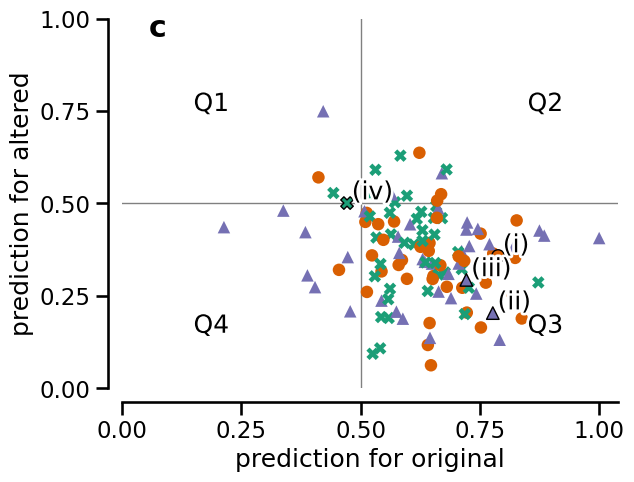

exp4 - quantile counts: Counter({'Q3': 49, 'Q2': 41, 'Q1': 16, 'Q4': 14})


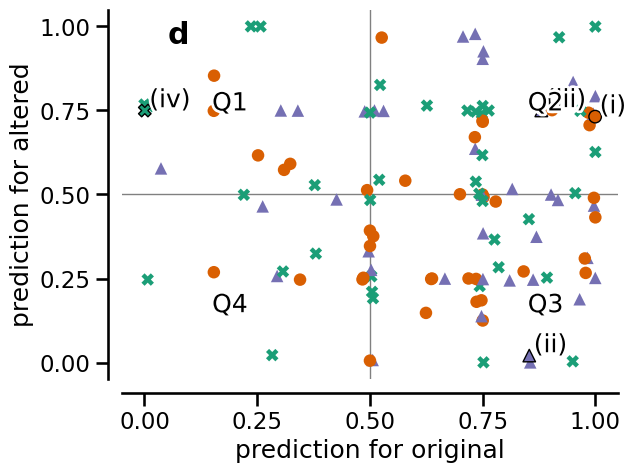

In [17]:

letters="abcd"
for key in ["average","metacmab","expertisetree","exp4"]:
    x0,y0=np.array(points["average"]).T
    x,y=np.array(points["average"]).T
    x1,y1=np.array(points[key]).T

    Q_dist = Counter(list(map({(True,False):'Q3',(True,True):'Q2',(False,True):'Q1',(False,False):'Q4'}.get,map(tuple,(np.array(points[key])>0.5)))))
    Q_counts_et =list( dict(sorted(Q_dist.items())).values())
    print(key,"- quantile counts:",Q_dist)


    sns.set_context("talk")
    plt.axhline(0.5,color="grey",zorder=1,linewidth=1)
    plt.axvline(0.5,color="grey",zorder=1,linewidth=1)
    markers = {"ethnicity":"o","age": "X", "gender": "^"}
    colormap = np.array(["C0" if c == "age" else "C1" if c== "ethnicity" else "C2" for c in classes])
    g=sns.scatterplot(x=x1,y=y1,palette="Dark2", markers=markers,style=classes,hue=classes,hue_order=('age','ethnicity','gender'),linewidth=0)
    sns.scatterplot(x=x1[np.array(colors)=='C1'],y=y1[np.array(colors)=='C1'],hue_order=('age','ethnicity','gender'),linewidth=1,hue=list(np.array(classes)[np.array(colors)=='C1']),palette="Dark2",markers=markers,style=list(np.array(classes)[np.array(colors)=='C1']),legend=False,edgecolor="black")
    labels=["i","ii","iii","iv",]
    for (a,b),c,h in zip(np.array([x1,y1]).T,colors,sorted(prol_data.original.unique())):
        if c=='C0':continue 
        plt.text(a+.01,b+.01,f"({labels[display_headlines.index(h)]})",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    

    plt.xticks([0,0.25,0.5,.75,1])
    plt.yticks([0,0.25,0.5,.75,1])

    sns.despine(offset=10)
    plt.xlabel("prediction for original")
    plt.ylabel("prediction for altered")

    plt.legend([],[], frameon=False)
    if key!="exp_weighted" :
        plt.text(0.075,.95,letters[0],weight="bold",ha='center',fontsize='large')
        letters = letters[1:]
    plt.text(0.15,.75,"Q1",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    plt.text(0.85,.75,"Q2",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    plt.text(0.85,.15,"Q3",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    plt.text(0.15,.15,"Q4",
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
                
    plt.savefig(os.path.join(figure_dir,f"scatter_real_altered_{key}.pdf"),bbox_inches="tight")
    plt.savefig(os.path.join(figure_dir,f"scatter_real_altered_{key}.svg"),bbox_inches="tight")
    plt.show()

## Accuracy as a function of response time

bootstrapping CIs...:   0%|          | 0/3101 [00:00<?, ?it/s]

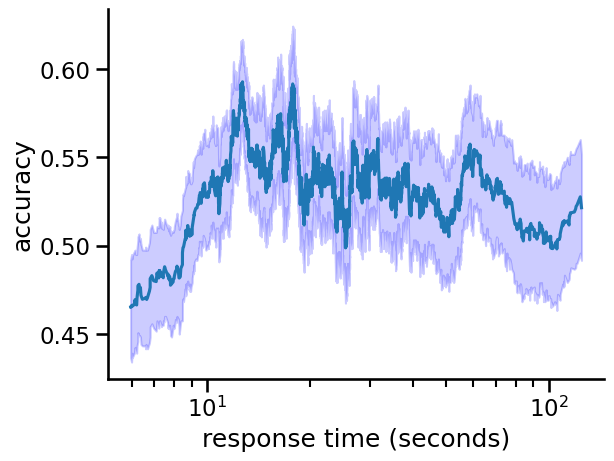

In [18]:


response_times,absolute_errors = prol_data.groupby(by=["expert_id","trial",]).mean(numeric_only=True).reset_index()[["trial_time","trial_error"]].values.T
response_time_indices = np.argsort(response_times)
sorted_response_times = response_times[response_time_indices]*60
performance = 1-absolute_errors[response_time_indices]

window_size = 100
half_window = window_size // 2 

n_bootstraps = 1000  
confidence_level = 0.95

# Function to calculate bootstrap confidence intervals for each window
def windowed_bootstrap_ci(window_data, n_bootstraps, confidence_level):
    bootstrap_means = np.array([
        np.mean(np.random.choice(window_data, size=window_data.shape[0], replace=True)) 
        for _ in range(n_bootstraps)
    ])
    lower_bound = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
    return np.mean(bootstrap_means), lower_bound, upper_bound
 

# Initialize lists to store the moving averages and confidence intervals
moving_averages = []
ci_lower = []
ci_upper = []

# Calculate moving averages and confidence intervals
for i in trange(len(performance) - window_size + 1,desc="bootstrapping CIs..."):
    window_data = performance[i:i+window_size]
    mean, lower, upper = windowed_bootstrap_ci(window_data, n_bootstraps, confidence_level)
    moving_averages.append(mean)
    ci_lower.append(lower)
    ci_upper.append(upper)

# Adjusting the x-axis values to align with the center of each window
adjusted_times = sorted_response_times[half_window:-half_window+1]

sns.set_context("talk")

plt.plot(adjusted_times, moving_averages)
plt.fill_between(adjusted_times, ci_lower, ci_upper, color='b', alpha=0.2)
plt.xlabel('response time (seconds)')
plt.ylabel('accuracy')

plt.xscale('log')

sns.despine()
plt.savefig(os.path.join(figure_dir,"time_to_accuracy.pdf"),bbox_inches="tight")
plt.show()
